# Fitting Power Law Distributions

In [1]:
import numpy as np
import plfit 
import scipy
import matplotlib.pyplot as plt
import networkx as nx

#Global Variables
pcheck = 500

Finding the value of alpha according to Eq 3.7

In [2]:
def finda(x, xmin):
    afind = np.log((x)/(xmin-0.5)) 
    a_ = 1 + len(afind)*((sum(afind)**(-1)))
    n = len(afind)
    #Finite correction
    a_ = a_*(n-1)/n + 1/n
    return a_

After obotaining the value of alpha, we look into a range of values around the guess, to widen our scope and obtain a more ideal value

In [3]:
def alpharange(alpha, a_values):
    return np.linspace(alpha*0.90, alpha*1.10, a_values) 

Among the values of alpha generated, the one that maximizes the log likelihood (As given in B.8) is the most ideal

In [4]:
def llhood(alphavals, xmin, x):
    temp = x[x >= xmin]
    n = len(temp)
    return (-n*np.log(scipy.special.zeta(alphavals, xmin)) - alphavals*np.sum(np.log(temp)))


The KS Statistic is calculated for all the (xmin, alpha) pairs and the one that yields the minimum difference between the two is chosen

In [5]:
def ks_value(alpha, xmin, x):
    temp = x[x >= xmin]
    n = len(temp)
    ecdf = np.searchsorted(temp, temp, side = 'left')/n
    cdf = 1 - (temp/xmin)**(-alpha + 1)
    return max(abs(ecdf - cdf))

All the unique values in the data are possible candidates for xmin and we iterate through all of them, and using the methods discussed abovefind the best fit 

In [6]:
def findxmin(x):
    x.sort()
    ks = np.array([])
    alpha_list = np.array([])
    xminvals = np.unique(x)
    for i in np.nditer(xminvals[:-1]):
        temp = x[x >= i]
        xmin = i
        alpha = finda(temp, xmin)
        alphavals = alpharange(alpha, 100)

        lhood = llhood(alphavals, xmin, temp)
        best_alpha = alphavals[np.argmax(lhood)]
        alpha_list = np.append(alpha_list, best_alpha)
        ks = np.append(ks, ks_value(best_alpha, xmin, temp))

    xmin_index = np.argmin(ks)
    xmin = xminvals[xmin_index]
    alpha = alpha_list[xmin_index]
    pdata = x[x >= xmin]
    n = len(pdata)
    sigma = (alpha - 1)/np.sqrt(n)
    ks = min(ks)
    



    
    return xmin, alpha, n, sigma, ks, pdata
    
        
        
        
    

In [7]:
def pplot(pdata, xmin, alpha):
    plt.loglog()
    m = np.unique(pdata)
    n = len(pdata)
    y = np.array([])
    
    for i in np.nditer(m):
        y = np.append(y, n - list(pdata).index(i))
    y /= n
        
    plt.scatter(m, y, label = "degree distribution")
    plt.scatter(m, (m/xmin)**(-alpha + 1), label = 'power law fit')
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.legend()
    plt.show()

Generating random numbers that follow powerlaw distribution according to the merhod described in Appendix D

In [8]:
def x_fn_above(u, xmin, alpha):
    # When r>=rmin.
    x = xmin * pow((1.-u), 1./(1.-alpha))
    return (x)

We generate ntail data points that follow a power law distribution using the function mentioned above. If n is the size of the data set, we pick n - ntail observations from the original data set that do not follow a powerlaw distribution.

Once the synthetic data is created, we fit it using the function above to calculate the KS value that is compared with that of the real data

In [9]:
def genp(xmin, alpha, ntail, ks, degree):
    nexp = len(degree) - ntail
    p = 0
    # Normalization factor:
    C = (1./xmin) * pow((1./(alpha-1) + (np.exp(alpha)-1)/alpha), -1)
    
    for i in range(pcheck):
        # random numbers from uniform distribution in range [0, 1):
        r = np.random.uniform(low = 0., high = 1, size = ntail)
       
        
        y_above = []
        for u in r:
            y_above.append(x_fn_above(u,  xmin-0.5, alpha))
        
        y_temp1 = y_above
        y_temp2 = np.array(y_temp1)
        y = np.round(y_temp2 + 0.5)
        x = y.astype(int)
        x = x[x>0]
    
        exp_data = np.random.choice(degree[degree < xmin], nexp)
        x = np.append(x, exp_data)
    
        ks_synthetic = findxmin(x)[4]
    
        if ks_synthetic > ks:
            p += 1
        else:
            pass
    
    p /= pcheck
    return p
    

In [10]:
g = nx.read_edgelist('protein.edgelist.txt')
degree = list(g.degree())
degree = np.array([x[1] for x in degree])
print (len(g), 2*len(g.edges())/len(g))

2018 2.9038652130822595


xmin = 6 alpha =  2.8552837536195383


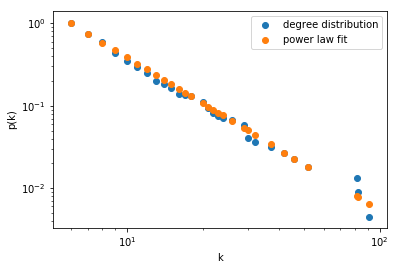

In [11]:
xmin, alpha, n, sigma, ks, pdata = findxmin(degree)
print ("xmin =", xmin, "alpha = ", alpha)
genp(xmin, alpha, n, ks, degree)
pplot(pdata, xmin, alpha)

In [12]:
g = nx.read_edgelist('powergrid.edgelist.txt')
degree = list(g.degree())
degree = np.array([x[1] for x in degree])
print (len(g), 2*len(g.edges())/len(g))

4941 2.66909532483303


xmin = 10 alpha =  7.623518211330042


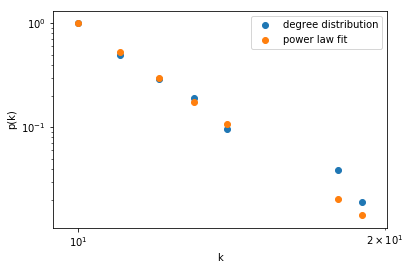

In [13]:
xmin, alpha, n, sigma, ks, pdata = findxmin(degree)
print ("xmin =", xmin, "alpha = ", alpha)
genp(xmin, alpha, n, ks, degree)
pplot(pdata, xmin, alpha)

In [14]:
g = nx.read_edgelist('www.edgelist.txt', create_using = nx.DiGraph)
degree = list(g.in_degree())
degree = np.array([x[1] for x in degree])
degree = degree[degree > 0]
print (len(g))
print (len(g), 2*len(g.edges())/len(g))

325729
325729 9.192512794378148


xmin = 5 alpha =  1.9334225883203586


C:\Users\gvaid\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


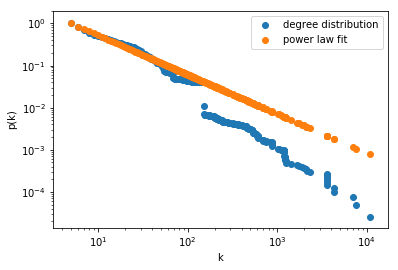

In [15]:
xmin, alpha, n, sigma, ks, pdata = findxmin(degree)
print ("xmin =", xmin, "alpha = ", alpha)
genp(xmin, alpha, n, ks, degree)
pplot(pdata, xmin, alpha)

In [16]:
g = nx.read_edgelist('www.edgelist.txt', create_using = nx.DiGraph)
degree = list(g.out_degree())
degree = np.array([x[1] for x in degree])
degree = degree[degree > 0]
print (len(g), 2*len(g.edges())/len(g))
print (len(degree))

325729 9.192512794378148
137941


xmin = 8 alpha =  2.0604240514749863


C:\Users\gvaid\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


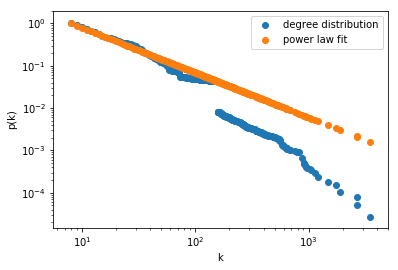

In [17]:
xmin, alpha, n, sigma, ks, pdata = findxmin(degree)
print ("xmin =", xmin, "alpha = ", alpha)
genp(xmin, alpha, n, ks, degree)
pplot(pdata, xmin, alpha)

In [18]:
g = nx.read_edgelist('metabolic.edgelist.txt', create_using = nx.DiGraph)
degree = list(g.degree())
degree = np.array([x[1] for x in degree])
degree = degree[degree > 0]
print (len(g))
print (len(g), 2*len(g.edges())/len(g))

1039
1039 11.168431183830606


xmin = 7 alpha =  2.6427071887459355


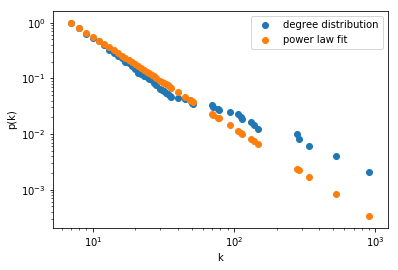

In [19]:
xmin, alpha, n, sigma, ks, pdata = findxmin(degree)
print ("xmin =", xmin, "alpha = ", alpha)
genp(xmin, alpha, n, ks, degree)
pplot(pdata, xmin, alpha)